In [ ]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Layer
from numpy import array
from numpy import hstack
from keras.layers import *
from keras.models import *
from keras import backend as K
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

[129.6326  132.4039  251.49748] [129.6326  132.4039  251.49748]


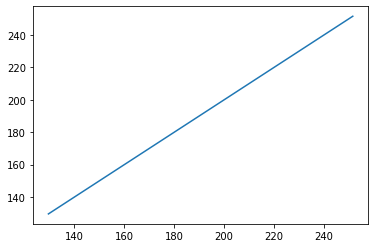

In [26]:

# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 
    

def stable_sigmoid(x):
    sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return sig

def inverse_sigmoid(x):
    inv_sig = -np.log((1 / (x + 1e-8)) - 1)
    return inv_sig

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq00 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq01 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])

in_seq = np.transpose((
    in_seq00, 
    in_seq01
))

scaler = StandardScaler()

#ensuring scaling isn't applied to test data

#in_seq = stable_sigmoid(in_seq)

in_seq00 = in_seq[:,0]
in_seq01 = in_seq[:,1]

out_seq = array([in_seq00[i]+in_seq01[i] for i in range(len(in_seq00))])
# convert to [rows, columns] structure
in_seq00 = in_seq00.reshape((len(in_seq00), 1))
in_seq01 = in_seq01.reshape((len(in_seq01), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = scaler.fit_transform(hstack((in_seq00, in_seq01, out_seq)))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(n_steps_in, n_features)))
model.add((LSTM(128, activation='tanh', return_sequences=True)))
model.add(attention(return_sequences=True)) #
model.add(RepeatVector(n_steps_out))
#model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = scaler.inverse_transform(*model.predict(x_input, verbose=0))
#print(yhat)

#y_ = inverse_sigmoid(y[-1])*scaler.scale_[0]+scaler.mean_[0]
#yhat = (yhat)*scaler.scale_[0]+scaler.mean_[0]
#print(y_)
print(*yhat)
#plt.plot(y_)
plt.plot(*yhat)
plt.show()

#rmse = mean_squared_error(y_, *yhat, squared=True)
#print("RMSE:",rmse,"MAPE:",MAPE(y_, yhat))